In [101]:
import os
import datetime
import time
import PIL
import json
import zipfile
import hashlib
import gc
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras import Model, layers
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.applications.inception_v3 as inc_v3
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [102]:
# Set random seeds for reproducibility
tf.random.set_seed(33)
np.random.seed(33)

# Constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 300
NUM_BATCHES = 40
D_STEPS = 3
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = 'logs/'

In [103]:
# Make sure log directory exists
os.makedirs(LOG_DIR, exist_ok=True)

In [104]:
data_path = 'data/'

# for kaggle nb
# import kagglehub
# data_path = kagglehub.competition_download('gan-getting-started')

In [105]:
monet_filenames= tf.io.gfile.glob(str(data_path + '/monet_jpg/*.jpg'))
photo_filenames = tf.io.gfile.glob(str(data_path + '/photo_jpg/*.jpg'))

In [106]:
print(f'Number of Monet files: {len(monet_filenames)}')
print(f'Number of photograph files: {len(photo_filenames)}')

Number of Monet files: 300
Number of photograph files: 7038


Monet image shape: (256, 256, 3)
Photo image shape: (256, 256, 3)


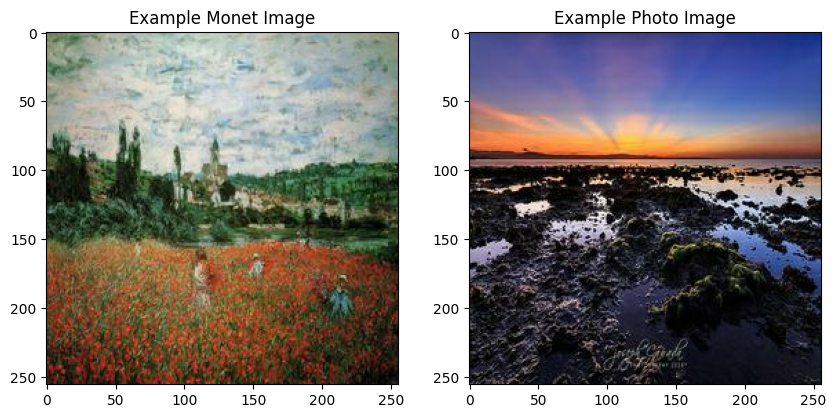

In [107]:
if monet_filenames and photo_filenames:
    example_monet_path = monet_filenames[random.randint(0, len(monet_filenames)) ]
    monet_image = tf.io.read_file(example_monet_path)
    monet_image = tf.image.decode_jpeg(monet_image, channels=3)
    print("Monet image shape:", monet_image.shape)

    example_photo_path = photo_filenames[random.randint(0, len(photo_filenames))]
    photo_image = tf.io.read_file(example_photo_path)
    photo_image = tf.image.decode_jpeg(photo_image, channels=3)
    print("Photo image shape:", photo_image.shape)
    
    # Display the images side by side
    plt.figure(figsize=(10, 5)) 

    # Show Monet image in the first subplot
    plt.subplot(1, 2, 2)
    plt.imshow(photo_image.numpy())
    plt.title("Example Photo Image")

    # Show Photo image in the second subplot
    plt.subplot(1, 2, 1)
    plt.imshow(monet_image.numpy())
    plt.title("Example Monet Image")

    plt.show()

In [108]:
# Initialize accumulators
total_pixels = 0
sum_rgb = np.zeros(3)
sum_sq_rgb = np.zeros(3)

for filename in monet_filenames:
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256]).numpy()
    
    sum_rgb += image.mean(axis=(0, 1))
    sum_sq_rgb += (image**2).mean(axis=(0, 1))
    total_pixels += 1

# Calculate final statistics
mean = sum_rgb / total_pixels
std = np.sqrt(sum_sq_rgb/total_pixels - mean**2)

print(f"Dataset Mean (RGB): {mean}")
print(f"Dataset Std (RGB): {std}")

Dataset Mean (RGB): [131.80562912 133.75694707 120.24496012]
Dataset Std (RGB): [57.85646349 56.16768997 62.97409039]


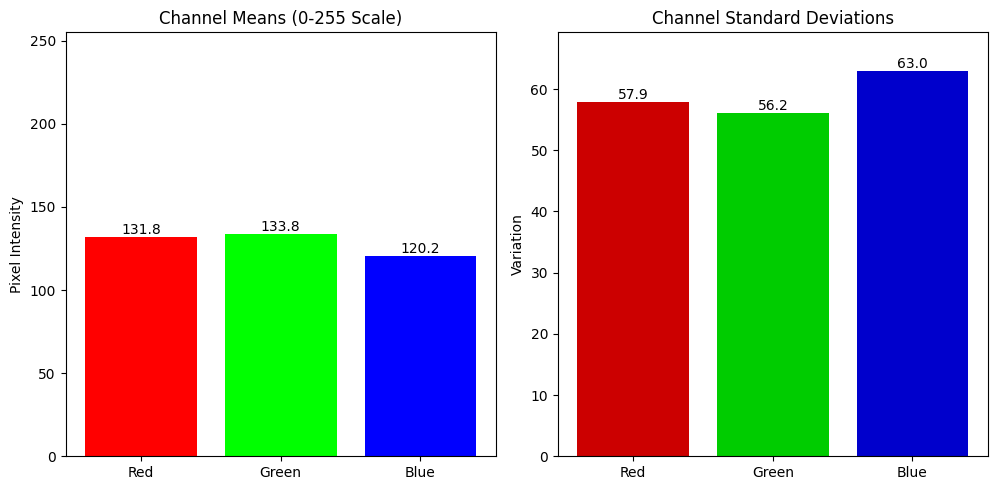

In [109]:
# Create figure with subplots
plt.figure(figsize=(15, 5))

# Plot 1: Channel means with color bars
plt.subplot(1, 3, 1)
bars = plt.bar(['Red', 'Green', 'Blue'], mean, 
               color=['#ff0000', '#00ff00', '#0000ff'])
plt.title('Channel Means (0-255 Scale)')
plt.ylabel('Pixel Intensity')
plt.ylim(0, 255)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

# Plot 2: Channel standard deviations
plt.subplot(1, 3, 2)
bars = plt.bar(['Red', 'Green', 'Blue'], std,
               color=['#cc0000', '#00cc00', '#0000cc'])
plt.title('Channel Standard Deviations')
plt.ylabel('Variation')
plt.ylim(0, np.max(std) * 1.1)

# Add exact values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [110]:
def preprocess_image(image_bytes):
    """Process raw image bytes into normalized tensors."""
    try:
        # Decode with explicit RGB conversion
        image = tf.image.decode_jpeg(image_bytes, channels=3)
        
        # Convert to float and resize
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH],
                              method=tf.image.ResizeMethod.BILINEAR)
        
        # Normalize to [-1, 1] range for tanh activation
        image = (image - 0.5) * 2.0
        
        # Ensure proper shape
        image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
        
        return image
        
    except tf.errors.InvalidArgumentError as e:
        print(f"Error processing image: {e}")
        return tf.zeros([IMG_HEIGHT, IMG_WIDTH, 3])  # Return blank image

def load_dataset(filenames, shuffle=True):
    """Create optimized TensorFlow Dataset pipeline."""
    # Validate input
    if not filenames:
        raise ValueError("Empty file list provided to load_dataset")
    
    # Create base dataset
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    
    # Shuffle filenames before reading
    if shuffle:
        dataset = dataset.shuffle(len(filenames), reshuffle_each_iteration=True)
    
    # Parallel file reading and preprocessing
    dataset = dataset.map(
        lambda x: tf.io.read_file(x),
        num_parallel_calls=AUTOTUNE
    )
    
    # Handle corrupt images
    dataset = dataset.map(
        preprocess_image,
        num_parallel_calls=AUTOTUNE
    ).apply(
        tf.data.experimental.ignore_errors()
    )
    return dataset

In [111]:
def get_dataset_length(dataset):
    """
    Returns the length of a tf.data.Dataset.
    If the cardinality is unknown, it iterates through the dataset to count elements.
    """
    cardinality = dataset.cardinality().numpy()
    if cardinality == tf.data.UNKNOWN_CARDINALITY:
        count = 0
        for _ in dataset:
            count += 1
        return count
    return cardinality


# Load the datasets with drop_remainder=True to ensure consistent batch sizes
monet_ds = load_dataset(monet_filenames, shuffle=True)
photo_ds = load_dataset(photo_filenames, shuffle=True)

# Ensure all batches have the same size by dropping incomplete batches
monet_ds = monet_ds.batch(BATCH_SIZE, drop_remainder=True)
photo_ds = photo_ds.batch(BATCH_SIZE, drop_remainder=True)

# Ensure equal number of batches
len_monet_ds, len_photo_ds = get_dataset_length(monet_ds), get_dataset_length(photo_ds)

In [112]:
# Oversample the Monet dataset: repeat it infinitely
monet_ds = monet_ds.repeat()

# To set num of batches per epoch to be defined by NUM_BATCHES
monet_ds = monet_ds.take(NUM_BATCHES)


In [113]:
# diagnostic logging
print("\nDataset Summary:")
print(f"Monet examples: {len(monet_filenames)}")
print(f"Photo examples: {len(photo_filenames)}")
print(f"Monet batches: {tf.data.experimental.cardinality(monet_ds)}")
print(f"Photo batches: {tf.data.experimental.cardinality(photo_ds)}")
print(f"Output signature: {monet_ds.element_spec}\n")


Dataset Summary:
Monet examples: 300
Photo examples: 7038
Monet batches: 40
Photo batches: -2
Output signature: TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)



In [114]:
# Quick sanity check
# Verify the diagnostic output, Check for any corruption warnings, Ensure the pixel ranges are [-1, 1], Confirm batch shapes are (16, 256, 256, 3)
for batch in monet_ds.take(1):
    print("Monet batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(), 
          tf.reduce_max(batch).numpy())

for batch in photo_ds.take(1):
    print("Photo batch shape:", batch.shape)
    print("Pixel range:", tf.reduce_min(batch).numpy(),
          tf.reduce_max(batch).numpy())

Monet batch shape: (32, 256, 256, 3)
Pixel range: -1.0 1.0
Photo batch shape: (32, 256, 256, 3)
Pixel range: -1.0 1.0


In [115]:
def build_generator(input_shape=(256, 256, 3), base_filters=64, use_attention=True):
    """
    Build an improved generator with proper normalization and skip connections.
    
    Args:
        input_shape: Input image shape (default: (256, 256, 3))
        base_filters: Number of base filters (default: 64)
        use_attention: Whether to use self-attention (default: True)
        
    Returns:
        Keras Model for the generator
    """
    # Weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Encoder blocks - extract features at different scales
    # Each block: Conv -> BatchNorm -> LeakyReLU
    
    # Block 1: (256x256x3) -> (128x128x64)
    e1 = layers.Conv2D(base_filters, 4, strides=2, padding='same', 
                      kernel_initializer=init)(inputs)
    e1 = layers.LeakyReLU(0.2)(e1)
    
    # Block 2: (128x128x64) -> (64x64x128)
    e2 = layers.Conv2D(base_filters*2, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU(0.2)(e2)
    
    # Block 3: (64x64x128) -> (32x32x256)
    e3 = layers.Conv2D(base_filters*4, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU(0.2)(e3)
    
    # Block 4: (32x32x256) -> (16x16x512)
    e4 = layers.Conv2D(base_filters*8, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e3)
    e4 = layers.BatchNormalization()(e4)
    e4 = layers.LeakyReLU(0.2)(e4)
    
    # Block 5: (16x16x512) -> (8x8x512)
    e5 = layers.Conv2D(base_filters*8, 4, strides=2, padding='same', 
                      kernel_initializer=init)(e4)
    e5 = layers.BatchNormalization()(e5)
    e5 = layers.LeakyReLU(0.2)(e5)
    
    # Bottleneck - add self-attention at the bottleneck
    bottleneck = e5
    
    # Apply self-attention at the bottleneck if requested
    if use_attention:
        bottleneck = SelfAttention(base_filters*8)(bottleneck)
    
    # Decoder blocks - upsample and concatenate with encoder features
    # Each block: ConvTranspose -> BatchNorm -> ReLU -> Concat with encoder
    
    # Block 1: (8x8x512) -> (16x16x512)
    d1 = layers.Conv2DTranspose(base_filters*8, 4, strides=2, padding='same', 
                               kernel_initializer=init)(bottleneck)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.ReLU()(d1)
    # Skip connection with e4
    d1 = layers.Concatenate()([d1, e4])
    
    # Block 2: (16x16x1024) -> (32x32x256)
    d2 = layers.Conv2DTranspose(base_filters*4, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.ReLU()(d2)
    # Skip connection with e3
    d2 = layers.Concatenate()([d2, e3])
    
    # Block 3: (32x32x512) -> (64x64x128)
    d3 = layers.Conv2DTranspose(base_filters*2, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.ReLU()(d3)
    # Skip connection with e2
    d3 = layers.Concatenate()([d3, e2])
    
    # Block 4: (64x64x256) -> (128x128x64)
    d4 = layers.Conv2DTranspose(base_filters, 4, strides=2, padding='same', 
                               kernel_initializer=init)(d3)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.ReLU()(d4)
    # Skip connection with e1
    d4 = layers.Concatenate()([d4, e1])
    
    # Output layer: (128x128x128) -> (256x256x3)
    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                   kernel_initializer=init, activation='tanh')(d4)
    
    # Create and return model
    model = Model(inputs=inputs, outputs=output, name="Generator")
    return model

# Simplified Self-Attention layer with improved numerical stability
class SelfAttention(layers.Layer):
    """
    Self-attention mechanism for GANs with improved stability.
    """
    def __init__(self, filters, reduction_ratio=8):
        super().__init__()
        self.filters = filters
        self.reduction_ratio = reduction_ratio
        
        # Reduced dimension for query and key (for efficiency)
        self.reduced_filters = max(filters // reduction_ratio, 1)
        
        # Initialize gamma parameter with zeros for gradual learning
        self.gamma = self.add_weight(
            name='gamma',
            shape=(),
            initializer='zeros',
            trainable=True
        )
        
        # Create convolution layers
        self.query_conv = layers.Conv2D(self.reduced_filters, 1, padding='same')
        self.key_conv = layers.Conv2D(self.reduced_filters, 1, padding='same')
        self.value_conv = layers.Conv2D(filters, 1, padding='same')
        
    def call(self, x):
        batch_size = tf.shape(x)[0]
        
        # Create query, key, and value projections
        query = self.query_conv(x)  # B×H×W×(C/r)
        key = self.key_conv(x)      # B×H×W×(C/r)
        value = self.value_conv(x)  # B×H×W×C
        
        # Reshape for attention computation
        hw = tf.shape(x)[1] * tf.shape(x)[2]
        
        # Reshape to matrices for matrix multiplication
        query_flat = tf.reshape(query, [batch_size, hw, self.reduced_filters])  # B×(H*W)×(C/r)
        key_flat = tf.reshape(key, [batch_size, hw, self.reduced_filters])      # B×(H*W)×(C/r)
        value_flat = tf.reshape(value, [batch_size, hw, self.filters])          # B×(H*W)×C
        
        # Calculate attention scores (B×(H*W)×(H*W))
        energy = tf.matmul(query_flat, key_flat, transpose_b=True)
        
        # Scale dot-product attention
        scale = tf.sqrt(tf.cast(self.reduced_filters, tf.float32))
        attention = tf.nn.softmax(energy / scale, axis=-1)
        
        # Apply attention to value
        out = tf.matmul(attention, value_flat)  # B×(H*W)×C
        
        # Reshape back to original shape
        out = tf.reshape(out, tf.shape(x))
        
        # Apply weighted residual connection
        return self.gamma * out + x

In [116]:
def build_discriminator(input_shape=(256, 256, 3), base_filters=64, use_sn=False, patchgan_output=True):
    """
    Build an improved PatchGAN discriminator with spectral normalization.
    
    Args:
        input_shape: Input image shape (default: (256, 256, 3))
        base_filters: Base filter count (default: 64)
        use_sn: Whether to use spectral normalization (default: True)
        patchgan_output: Whether to use PatchGAN output (default: True)
        
    Returns:
        Keras Model for the discriminator
    """
    # Weight initialization for GAN stability
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # First conv without normalization
    x = layers.Conv2D(base_filters, 4, strides=2, padding='same', 
                      kernel_initializer=init)(inputs)
    x = layers.LeakyReLU(0.2)(x)
    
    # Stack of increasing filter size Conv blocks
    # Each block: Conv -> (Spectral)Norm -> LeakyReLU
    filter_sizes = [base_filters*2, base_filters*4, base_filters*8]
    
    for i, filters in enumerate(filter_sizes):
        conv = layers.Conv2D(filters, 4, strides=2, padding='same', 
                            kernel_initializer=init)
        
        # Apply spectral normalization if requested
        if use_sn:
            conv = layers.SpectralNormalization(conv)
            
        x = conv(x)
        
        # Use instance normalization instead of batch normalization for better stability
        # Don't use normalization with spectral norm in the same layer
        if not use_sn:
            x = layers.BatchNormalization()(x)
            
        x = layers.LeakyReLU(0.2)(x)
    
    # Apply self-attention after sufficient downsampling
    x = SelfAttention(base_filters*8)(x)
    
    # Final convolution layer
    if patchgan_output:
        # PatchGAN output - don't use global pooling
        x = layers.Conv2D(1, 4, padding='same', kernel_initializer=init)(x)
    else:
        # Classify entire image (original approach)
        x = layers.Conv2D(base_filters*8, 4, padding='same', kernel_initializer=init)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Conv2D(1, 4, padding='same', kernel_initializer=init)(x)
        x = layers.GlobalAveragePooling2D()(x)
    
    # Create and return model
    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

# Simplified residual block for optional use
def residual_block(x, filters, use_sn=True, downsample=False):
    """
    Residual block with optional spectral normalization and downsampling.
    
    Args:
        x: Input tensor
        filters: Number of filters
        use_sn: Whether to use spectral normalization
        downsample: Whether to downsample spatially
        
    Returns:
        Output tensor
    """
    shortcut = x
    
    # First convolution
    conv1 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv1 = layers.SpectralNormalization(conv1)
    
    x = conv1(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Second convolution
    conv2 = layers.Conv2D(filters, 3, padding='same')
    if use_sn:
        conv2 = layers.SpectralNormalization(conv2)
    
    x = conv2(x)
    
    # Downsample if requested (after both convolutions)
    if downsample:
        x = layers.AveragePooling2D()(x)
        shortcut = layers.AveragePooling2D()(shortcut)
    
    # Adjust shortcut dimension if needed
    if shortcut.shape[-1] != filters:
        shortcut_conv = layers.Conv2D(filters, 1, padding='same')
        if use_sn:
            shortcut_conv = layers.SpectralNormalization(shortcut_conv)
        shortcut = shortcut_conv(shortcut)
    
    # Add residual connection
    return layers.Add()([x, shortcut])

In [117]:
class WGANGPLoss:
    def __init__(self, lambda_gp=10.0, drift_penalty_weight=0.001, epsilon=1e-8):
        """
        Initialize WGAN-GP loss with parameters.
        
        Args:
            lambda_gp: Gradient penalty coefficient (default: 10.0)
            drift_penalty_weight: Coefficient for drift penalty (default: 0.001)
            epsilon: Small constant for numerical stability
        """
        self.lambda_gp = lambda_gp
        self.drift_penalty_weight = drift_penalty_weight  # Renamed to avoid method name conflict
        self.epsilon = epsilon
        
    def discriminator_loss(self, real_scores, fake_scores):
        """
        Wasserstein discriminator loss: maximize real scores, minimize fake scores.
        
        Args:
            real_scores: Output from real images (shape: [batch_size, 1])
            fake_scores: Output from generated images (shape: [batch_size, 1])
            
        Returns:
            Discriminator loss (scalar)
        """
        # In WGAN, discriminator wants to maximize: E[D(real)] - E[D(fake)]
        # Since we're minimizing, we use: E[D(fake)] - E[D(real)]
        real_loss = tf.reduce_mean(real_scores)
        fake_loss = tf.reduce_mean(fake_scores)
        
        # Calculate Wasserstein distance estimate
        wasserstein_distance = fake_loss - real_loss
        
        # Add metrics for monitoring (these work with TensorBoard)
        tf.summary.scalar('d_real_mean', real_loss)
        tf.summary.scalar('d_fake_mean', fake_loss)
        tf.summary.scalar('wasserstein_distance', wasserstein_distance)
        
        return wasserstein_distance
    
    def generator_loss(self, fake_scores):
        """
        Wasserstein generator loss: maximize fake scores.
        
        Args:
            fake_scores: Discriminator output for generated images
            
        Returns:
            Generator loss (scalar)
        """
        # In WGAN, generator wants to maximize: E[D(fake)]
        # Since we're minimizing, we use: -E[D(fake)]
        loss = -tf.reduce_mean(fake_scores)
        
        # Monitoring
        tf.summary.scalar('g_fake_mean', -loss)
        
        return loss

    def gradient_penalty(self, real_images, fake_images, discriminator):
        """
        Calculate WGAN-GP gradient penalty with improved numerical stability.
        
        Args:
            real_images: Batch of real images
            fake_images: Batch of generated images
            discriminator: Discriminator model
            
        Returns:
            Gradient penalty term (scalar)
        """
        # Get batch size dynamically
        batch_size = tf.shape(real_images)[0]
        
        # Generate random interpolation factors
        alpha = tf.random.uniform(
            shape=[batch_size, 1, 1, 1],
            minval=0.0,
            maxval=1.0
        )
        
        # Create interpolated images
        interpolated = real_images + alpha * (fake_images - real_images)
        
        # Calculate gradients
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            # Get discriminator prediction for interpolated images
            pred = discriminator(interpolated, training=True)
        
        # Calculate gradients of predictions with respect to images
        gradients = tape.gradient(pred, interpolated)
        
        # Calculate the Euclidean norm of the gradients (add epsilon for stability)
        gradients_sqr = tf.square(gradients)
        gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=[1, 2, 3])
        gradient_l2_norm = tf.sqrt(gradients_sqr_sum + self.epsilon)
        
        # Calculate penalty using (||∇D(x)||_2 - 1)²
        gradient_penalty = tf.reduce_mean(tf.square(gradient_l2_norm - 1.0))
        
        # Monitor gradient norms
        tf.summary.scalar('gradient_penalty', gradient_penalty)
        tf.summary.histogram('gradient_norms', gradient_l2_norm)
        
        return self.lambda_gp * gradient_penalty

    def compute_drift_penalty(self, real_scores):  # Renamed method to avoid conflict
        """
        Apply drift penalty to prevent discriminator scores from drifting too far.
        
        Args:
            real_scores: Discriminator output for real images
            
        Returns:
            Drift penalty term (scalar)
        """
        # Penalize large values in discriminator output
        penalty = tf.reduce_mean(tf.square(real_scores))
        return self.drift_penalty_weight * penalty

In [118]:
# Function to save sample images from the generator
def save_sample_images(generated_images, epoch):
    """
    Saves a grid of generated images for visual inspection.
    
    Args:
        generated_images: Tensor of generated images (assumed to be in range [-1, 1])
        epoch: Current epoch number (used for the filename)
    """
    # Rescale images from [-1, 1] to [0, 255]
    generated_images = (generated_images * 127.5 + 127.5)
    generated_images = tf.cast(generated_images, tf.uint8)
    
    # Determine grid size (square grid)
    num_images = generated_images.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create the subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    axes = axes.flatten()
    
    # Plot each image
    for i in range(num_images):
        axes[i].imshow(generated_images[i].numpy())
        axes[i].axis('off')
    
    # Remove extra axes if any
    for i in range(num_images, len(axes)):
        axes[i].remove()
    
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    image_path = f'samples/sample_epoch_{epoch:03d}.png'
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    plt.savefig(image_path)
    plt.close()

In [119]:
# Build models with the improved implementations
generator = build_generator(input_shape=(256, 256, 3), base_filters=64)
discriminator = build_discriminator(input_shape=(256, 256, 3), base_filters=64, patchgan_output=True)

# Create optimizers with adjusted parameters for better stability
g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# Initialize loss with adjusted parameters
LOSS = WGANGPLoss(lambda_gp=10.0, drift_penalty_weight=0.001)

# Define training metrics for monitoring
train_metrics = {
    'g_loss': tf.keras.metrics.Mean(name='g_loss'),
    'd_loss': tf.keras.metrics.Mean(name='d_loss'),
    'gp_loss': tf.keras.metrics.Mean(name='gp_loss'),
    'real_score': tf.keras.metrics.Mean(name='real_score'),
    'fake_score': tf.keras.metrics.Mean(name='fake_score')
}



@tf.function
def train_step(real_monet, real_photo):
    """
    Single training step for Monet GAN.
    
    Args:
        real_monet: Batch of real Monet paintings
        real_photo: Batch of real photographs
        
    Returns:
        Dictionary of loss values for logging
    """
    # Train discriminator multiple times per generator step
    for _ in range(D_STEPS):
        with tf.GradientTape() as d_tape:
            # Generate fake Monet paintings
            fake_monet = generator(real_photo, training=True)
            
            # Get discriminator outputs
            real_output = discriminator(real_monet, training=True)
            fake_output = discriminator(fake_monet, training=True)
            
            # Calculate discriminator losses
            d_gan_loss = LOSS.discriminator_loss(real_output, fake_output)
            gp_loss = LOSS.gradient_penalty(real_monet, fake_monet, discriminator)
            drift_loss = LOSS.compute_drift_penalty(real_output)  # Use the renamed method
            
            # Total discriminator loss
            total_d_loss = d_gan_loss + gp_loss + drift_loss
        
        # Apply discriminator gradients
        d_gradients = d_tape.gradient(total_d_loss, discriminator.trainable_variables)
        
        # Clip gradients for stability (optional)
        d_gradients, _ = tf.clip_by_global_norm(d_gradients, 1.0)
        
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    
    # Train generator
    with tf.GradientTape() as g_tape:
        # Generate fake images
        fake_monet = generator(real_photo, training=True)
        
        # Get discriminator output for generated images
        fake_output = discriminator(fake_monet, training=True)
        
        # Calculate generator loss
        g_loss = LOSS.generator_loss(fake_output)
    
    # Apply generator gradients
    g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    
    # Clip gradients for stability (optional)
    g_gradients, _ = tf.clip_by_global_norm(g_gradients, 1.0)
    
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    # Update metrics
    train_metrics['g_loss'].update_state(g_loss)
    train_metrics['d_loss'].update_state(d_gan_loss)
    train_metrics['gp_loss'].update_state(gp_loss)
    train_metrics['real_score'].update_state(tf.reduce_mean(real_output))
    train_metrics['fake_score'].update_state(tf.reduce_mean(fake_output))
    
    # Return losses for logging
    return {
        'd_loss': d_gan_loss,
        'g_loss': g_loss,
        'gp_loss': gp_loss,
        'real_score': tf.reduce_mean(real_output),
        'fake_score': tf.reduce_mean(fake_output)
    }

# Create a function to reset metrics at the start of each epoch
def reset_metrics():
    for metric in train_metrics.values():
        if hasattr(metric, "reset_states"):
            metric.reset_states()
        else:
            metric.reset_state()

# Main training loop with improved monitoring and checkpointing
def train_gan(epochs=EPOCHS, save_interval=5):
    """
    Train the Monet GAN for specified number of epochs with memory optimizations.
    
    Args:
        epochs: Number of training epochs
        save_interval: Interval for saving checkpoints
    """
    # Create checkpoint manager
    checkpoint_dir = './checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(
        generator=generator,
        discriminator=discriminator,
        g_optimizer=g_optimizer,
        d_optimizer=d_optimizer
    )
    manager = tf.train.CheckpointManager(
        checkpoint, checkpoint_dir, max_to_keep=3)
    
    # Try to restore from checkpoint
    if manager.latest_checkpoint:
        checkpoint.restore(manager.latest_checkpoint)
        print(f"Restored from checkpoint: {manager.latest_checkpoint}")
      
    # Enable memory growth to prevent OOM errors
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth enabled on GPU")
        except:
            print("Memory growth can't be enabled")
    
    for epoch in range(epochs):
        start_time = time.time()
        reset_metrics()
        
        # Use a fixed number of batches per epoch to prevent memory issues
        monet_batches = monet_ds.take(NUM_BATCHES)
        photo_batches = photo_ds.take(NUM_BATCHES)  # Match Monet dataset size
        
        # Create progress bar for batches
        batch_bar = tqdm(
            tf.data.Dataset.zip((photo_batches, monet_batches)), 
            desc=f"Epoch {epoch+1:03d}",
            total=NUM_BATCHES
        )
        
        
        # Train on batches
        for i, (photo_batch, monet_batch) in enumerate(batch_bar):
            
            # Perform training step
            step_losses = train_step(monet_batch, photo_batch)
            
            # Update progress bar with current losses
            batch_bar.set_postfix({
                'D Loss': f"{step_losses['d_loss']:.3f}",
                'G Loss': f"{step_losses['g_loss']:.3f}",
                'D Real': f"{step_losses['real_score']:.3f}",
                'D Fake': f"{step_losses['fake_score']:.3f}"
            })
        
        # Calculate epoch time
        epoch_time = time.time() - start_time
        
        # Print epoch summary
        print(f"\n=== Epoch {epoch+1}/{epochs} Summary ===")
        print(f"Duration:         {epoch_time:.2f}s")
        print(f"D Loss:           {train_metrics['d_loss'].result():.3f}")
        print(f"G Loss:           {train_metrics['g_loss'].result():.3f}")
        print(f"Real Score:       {train_metrics['real_score'].result():.3f}")
        print(f"Fake Score:       {train_metrics['fake_score'].result():.3f}")
        print(f"GP Loss:          {train_metrics['gp_loss'].result():.3f}")
        print(f"Learning Rate:    {g_optimizer.learning_rate.numpy():.2e}")
        print("====================================\n")
        
        # Save checkpoint at intervals
        if (epoch + 1) % save_interval == 0:
            manager.save()
            print(f"Saved checkpoint at epoch {epoch+1}")
            
            # Generate and save sample images for visual inspection
            sample_photo = next(iter(photo_ds.take(1)))
            generated_images = generator(sample_photo, training=False)
            
            # Save sample images with reduced memory usage
            # Use a reduced sample size if memory issues persist
            save_sample_images(generated_images[:min(16, len(generated_images))], epoch + 1)
            
        # Reduce learning rate if losses are unstable
        if epoch > 0 and epoch % 10 == 0:
            g_optimizer.learning_rate.assign(g_optimizer.learning_rate * 0.9)
            d_optimizer.learning_rate.assign(d_optimizer.learning_rate * 0.9)
            print(f"Reduced learning rate to {g_optimizer.learning_rate.numpy():.2e}")
            
        # Force garbage collection between epochs
        gc.collect()
    
    # Save final model
    manager.save()
    print("Training completed!")

In [120]:
# Start training -----------------------------------------------------------------

print(f"Final dataset sizes: {len_monet_ds} Monet batches, {len_photo_ds} Photo batches")
sample_monet, sample_photo = next(iter(zip(monet_ds, photo_ds)))
print("Sample batch shapes:")
print(f"Monet: {sample_monet.shape}, Photo: {sample_photo.shape}")

# Get batches to check shapes
sample_photo_batch = next(iter(photo_ds.take(1)))
sample_monet_batch = next(iter(monet_ds.take(1)))

# Generate output batch
generated_batch = generator(sample_photo_batch)

# Check shapes (ignoring batch dimension)
assert generated_batch.shape[1:] == sample_monet_batch.shape[1:], \
    f"Shape mismatch: Generator output {generated_batch.shape[1:]} vs Monet {sample_monet_batch.shape[1:]}"

# Check single sample prediction
single_photo = sample_photo_batch[0:1]  # maintain batch dimension
single_monet = sample_monet_batch[0:1]
assert generator(single_photo).shape == single_monet.shape, "Single sample prediction shape mismatch."

# Create output directories
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs('generated_images', exist_ok=True)
os.makedirs('samples', exist_ok=True)

# Make photo_ds infinite (for random sampling) while keeping monet_ds finite.
photo_ds = photo_ds.repeat().shuffle(BUFFER_SIZE)

# Start training using the new train_gan function
print("Starting training...")
train_gan(epochs=EPOCHS, save_interval=5)

Final dataset sizes: 9 Monet batches, 219 Photo batches
Sample batch shapes:
Monet: (32, 256, 256, 3), Photo: (32, 256, 256, 3)
Starting training...
Restored from checkpoint: ./checkpoints/ckpt-7


Epoch 001: 100%|██████████| 40/40 [12:39<00:00, 18.98s/it, D Loss=-0.013, G Loss=-0.129, D Real=0.211, D Fake=0.129] 



=== Epoch 1/300 Summary ===
Duration:         759.17s
D Loss:           -0.021
G Loss:           -0.063
Real Score:       0.094
Fake Score:       0.063
GP Loss:          0.031
Learning Rate:    8.10e-05



Epoch 002: 100%|██████████| 40/40 [12:22<00:00, 18.56s/it, D Loss=0.005, G Loss=-0.164, D Real=0.153, D Fake=0.164] 



=== Epoch 2/300 Summary ===
Duration:         742.44s
D Loss:           -0.020
G Loss:           -0.142
Real Score:       0.169
Fake Score:       0.142
GP Loss:          0.022
Learning Rate:    8.10e-05



Epoch 003: 100%|██████████| 40/40 [12:23<00:00, 18.58s/it, D Loss=-0.024, G Loss=-0.034, D Real=0.008, D Fake=0.034] 



=== Epoch 3/300 Summary ===
Duration:         743.31s
D Loss:           -0.020
G Loss:           -0.046
Real Score:       0.071
Fake Score:       0.046
GP Loss:          0.023
Learning Rate:    8.10e-05



Epoch 004: 100%|██████████| 40/40 [12:19<00:00, 18.48s/it, D Loss=-0.026, G Loss=-0.316, D Real=0.342, D Fake=0.316]



=== Epoch 4/300 Summary ===
Duration:         739.27s
D Loss:           -0.019
G Loss:           -0.166
Real Score:       0.196
Fake Score:       0.166
GP Loss:          0.022
Learning Rate:    8.10e-05



Epoch 005: 100%|██████████| 40/40 [12:21<00:00, 18.54s/it, D Loss=-0.027, G Loss=0.175, D Real=-0.026, D Fake=-0.175]



=== Epoch 5/300 Summary ===
Duration:         741.65s
D Loss:           -0.023
G Loss:           -0.081
Real Score:       0.125
Fake Score:       0.081
GP Loss:          0.029
Learning Rate:    8.10e-05

Saved checkpoint at epoch 5


Epoch 006: 100%|██████████| 40/40 [12:18<00:00, 18.45s/it, D Loss=-0.023, G Loss=-0.078, D Real=0.097, D Fake=0.078] 



=== Epoch 6/300 Summary ===
Duration:         738.17s
D Loss:           -0.026
G Loss:           -0.047
Real Score:       0.082
Fake Score:       0.047
GP Loss:          0.031
Learning Rate:    8.10e-05



Epoch 007: 100%|██████████| 40/40 [12:06<00:00, 18.17s/it, D Loss=-0.016, G Loss=0.037, D Real=0.042, D Fake=-0.037] 



=== Epoch 7/300 Summary ===
Duration:         726.70s
D Loss:           -0.019
G Loss:           -0.105
Real Score:       0.135
Fake Score:       0.105
GP Loss:          0.026
Learning Rate:    8.10e-05



Epoch 008: 100%|██████████| 40/40 [12:04<00:00, 18.11s/it, D Loss=0.004, G Loss=-0.016, D Real=0.035, D Fake=0.016]  



=== Epoch 8/300 Summary ===
Duration:         724.29s
D Loss:           -0.021
G Loss:           -0.082
Real Score:       0.106
Fake Score:       0.082
GP Loss:          0.029
Learning Rate:    8.10e-05



Epoch 009: 100%|██████████| 40/40 [12:07<00:00, 18.19s/it, D Loss=-0.035, G Loss=-0.058, D Real=0.240, D Fake=0.058] 



=== Epoch 9/300 Summary ===
Duration:         727.69s
D Loss:           -0.022
G Loss:           -0.049
Real Score:       0.080
Fake Score:       0.049
GP Loss:          0.022
Learning Rate:    8.10e-05



Epoch 010: 100%|██████████| 40/40 [12:05<00:00, 18.15s/it, D Loss=-0.047, G Loss=0.132, D Real=-0.005, D Fake=-0.132]



=== Epoch 10/300 Summary ===
Duration:         726.00s
D Loss:           -0.022
G Loss:           -0.017
Real Score:       0.049
Fake Score:       0.017
GP Loss:          0.020
Learning Rate:    8.10e-05

Saved checkpoint at epoch 10


Epoch 011: 100%|██████████| 40/40 [12:07<00:00, 18.19s/it, D Loss=-0.022, G Loss=-0.080, D Real=0.065, D Fake=0.080] 



=== Epoch 11/300 Summary ===
Duration:         727.53s
D Loss:           -0.022
G Loss:           -0.096
Real Score:       0.124
Fake Score:       0.096
GP Loss:          0.026
Learning Rate:    8.10e-05

Reduced learning rate to 7.29e-05


Epoch 012: 100%|██████████| 40/40 [12:06<00:00, 18.16s/it, D Loss=-0.019, G Loss=-0.061, D Real=0.037, D Fake=0.061] 



=== Epoch 12/300 Summary ===
Duration:         726.53s
D Loss:           -0.022
G Loss:           -0.031
Real Score:       0.055
Fake Score:       0.031
GP Loss:          0.022
Learning Rate:    7.29e-05



Epoch 013: 100%|██████████| 40/40 [12:06<00:00, 18.17s/it, D Loss=-0.026, G Loss=-0.180, D Real=0.226, D Fake=0.180] 



=== Epoch 13/300 Summary ===
Duration:         726.84s
D Loss:           -0.024
G Loss:           -0.052
Real Score:       0.086
Fake Score:       0.052
GP Loss:          0.020
Learning Rate:    7.29e-05



Epoch 014: 100%|██████████| 40/40 [12:05<00:00, 18.14s/it, D Loss=-0.056, G Loss=-0.082, D Real=0.155, D Fake=0.082] 



=== Epoch 14/300 Summary ===
Duration:         725.59s
D Loss:           -0.028
G Loss:           -0.079
Real Score:       0.117
Fake Score:       0.079
GP Loss:          0.025
Learning Rate:    7.29e-05



Epoch 015: 100%|██████████| 40/40 [12:05<00:00, 18.14s/it, D Loss=-0.019, G Loss=0.221, D Real=-0.083, D Fake=-0.221]



=== Epoch 15/300 Summary ===
Duration:         725.46s
D Loss:           -0.032
G Loss:           -0.062
Real Score:       0.106
Fake Score:       0.062
GP Loss:          0.020
Learning Rate:    7.29e-05

Saved checkpoint at epoch 15


Epoch 016: 100%|██████████| 40/40 [12:06<00:00, 18.17s/it, D Loss=-0.028, G Loss=-0.353, D Real=0.297, D Fake=0.353]



=== Epoch 16/300 Summary ===
Duration:         726.72s
D Loss:           -0.027
G Loss:           -0.105
Real Score:       0.133
Fake Score:       0.105
GP Loss:          0.021
Learning Rate:    7.29e-05



Epoch 017: 100%|██████████| 40/40 [12:05<00:00, 18.14s/it, D Loss=-0.042, G Loss=-0.150, D Real=0.269, D Fake=0.150] 



=== Epoch 17/300 Summary ===
Duration:         725.60s
D Loss:           -0.027
G Loss:           -0.056
Real Score:       0.090
Fake Score:       0.056
GP Loss:          0.020
Learning Rate:    7.29e-05



Epoch 018: 100%|██████████| 40/40 [12:06<00:00, 18.15s/it, D Loss=-0.019, G Loss=-0.061, D Real=0.108, D Fake=0.061] 



=== Epoch 18/300 Summary ===
Duration:         726.07s
D Loss:           -0.028
G Loss:           -0.101
Real Score:       0.139
Fake Score:       0.101
GP Loss:          0.022
Learning Rate:    7.29e-05



Epoch 019: 100%|██████████| 40/40 [12:06<00:00, 18.16s/it, D Loss=-0.033, G Loss=0.084, D Real=-0.142, D Fake=-0.084]



=== Epoch 19/300 Summary ===
Duration:         726.57s
D Loss:           -0.026
G Loss:           -0.036
Real Score:       0.073
Fake Score:       0.036
GP Loss:          0.019
Learning Rate:    7.29e-05



Epoch 020: 100%|██████████| 40/40 [12:04<00:00, 18.12s/it, D Loss=-0.030, G Loss=0.061, D Real=-0.017, D Fake=-0.061]



=== Epoch 20/300 Summary ===
Duration:         724.86s
D Loss:           -0.027
G Loss:           -0.053
Real Score:       0.090
Fake Score:       0.053
GP Loss:          0.019
Learning Rate:    7.29e-05

Saved checkpoint at epoch 20


Epoch 021: 100%|██████████| 40/40 [12:06<00:00, 18.16s/it, D Loss=-0.056, G Loss=0.073, D Real=0.012, D Fake=-0.073] 



=== Epoch 21/300 Summary ===
Duration:         726.54s
D Loss:           -0.029
G Loss:           0.007
Real Score:       0.023
Fake Score:       -0.007
GP Loss:          0.023
Learning Rate:    7.29e-05

Reduced learning rate to 6.56e-05


Epoch 022: 100%|██████████| 40/40 [12:07<00:00, 18.18s/it, D Loss=-0.022, G Loss=-0.104, D Real=0.197, D Fake=0.104] 



=== Epoch 22/300 Summary ===
Duration:         727.06s
D Loss:           -0.027
G Loss:           -0.054
Real Score:       0.092
Fake Score:       0.054
GP Loss:          0.015
Learning Rate:    6.56e-05



Epoch 023: 100%|██████████| 40/40 [12:07<00:00, 18.18s/it, D Loss=-0.017, G Loss=-0.017, D Real=0.062, D Fake=0.017] 



=== Epoch 23/300 Summary ===
Duration:         727.13s
D Loss:           -0.031
G Loss:           -0.016
Real Score:       0.056
Fake Score:       0.016
GP Loss:          0.017
Learning Rate:    6.56e-05



Epoch 024: 100%|██████████| 40/40 [12:07<00:00, 18.19s/it, D Loss=-0.036, G Loss=0.140, D Real=-0.052, D Fake=-0.140]



=== Epoch 24/300 Summary ===
Duration:         727.69s
D Loss:           -0.032
G Loss:           -0.048
Real Score:       0.090
Fake Score:       0.048
GP Loss:          0.018
Learning Rate:    6.56e-05



Epoch 025: 100%|██████████| 40/40 [12:04<00:00, 18.10s/it, D Loss=-0.017, G Loss=0.095, D Real=-0.072, D Fake=-0.095]



=== Epoch 25/300 Summary ===
Duration:         724.09s
D Loss:           -0.031
G Loss:           -0.034
Real Score:       0.067
Fake Score:       0.034
GP Loss:          0.016
Learning Rate:    6.56e-05

Saved checkpoint at epoch 25


Epoch 026: 100%|██████████| 40/40 [12:06<00:00, 18.15s/it, D Loss=-0.035, G Loss=0.099, D Real=-0.048, D Fake=-0.099]



=== Epoch 26/300 Summary ===
Duration:         726.11s
D Loss:           -0.032
G Loss:           -0.019
Real Score:       0.058
Fake Score:       0.019
GP Loss:          0.015
Learning Rate:    6.56e-05



Epoch 027: 100%|██████████| 40/40 [12:05<00:00, 18.14s/it, D Loss=-0.027, G Loss=-0.087, D Real=0.104, D Fake=0.087] 



=== Epoch 27/300 Summary ===
Duration:         725.55s
D Loss:           -0.029
G Loss:           -0.134
Real Score:       0.172
Fake Score:       0.134
GP Loss:          0.019
Learning Rate:    6.56e-05



Epoch 028: 100%|██████████| 40/40 [12:04<00:00, 18.12s/it, D Loss=-0.008, G Loss=-0.149, D Real=0.190, D Fake=0.149] 



=== Epoch 28/300 Summary ===
Duration:         724.77s
D Loss:           -0.031
G Loss:           -0.064
Real Score:       0.107
Fake Score:       0.064
GP Loss:          0.016
Learning Rate:    6.56e-05



Epoch 029: 100%|██████████| 40/40 [12:07<00:00, 18.19s/it, D Loss=-0.017, G Loss=-0.198, D Real=0.165, D Fake=0.198] 



=== Epoch 29/300 Summary ===
Duration:         727.68s
D Loss:           -0.034
G Loss:           -0.065
Real Score:       0.108
Fake Score:       0.065
GP Loss:          0.016
Learning Rate:    6.56e-05



Epoch 030: 100%|██████████| 40/40 [12:07<00:00, 18.18s/it, D Loss=-0.026, G Loss=0.048, D Real=-0.012, D Fake=-0.048]



=== Epoch 30/300 Summary ===
Duration:         727.39s
D Loss:           -0.035
G Loss:           -0.065
Real Score:       0.108
Fake Score:       0.065
GP Loss:          0.016
Learning Rate:    6.56e-05

Saved checkpoint at epoch 30


Epoch 031: 100%|██████████| 40/40 [12:09<00:00, 18.25s/it, D Loss=-0.024, G Loss=-0.013, D Real=0.097, D Fake=0.013] 



=== Epoch 31/300 Summary ===
Duration:         729.88s
D Loss:           -0.032
G Loss:           -0.069
Real Score:       0.110
Fake Score:       0.069
GP Loss:          0.021
Learning Rate:    6.56e-05

Reduced learning rate to 5.90e-05


Epoch 032: 100%|██████████| 40/40 [12:08<00:00, 18.22s/it, D Loss=-0.049, G Loss=-0.131, D Real=0.165, D Fake=0.131] 



=== Epoch 32/300 Summary ===
Duration:         728.87s
D Loss:           -0.032
G Loss:           -0.013
Real Score:       0.050
Fake Score:       0.013
GP Loss:          0.016
Learning Rate:    5.90e-05



Epoch 033: 100%|██████████| 40/40 [12:08<00:00, 18.22s/it, D Loss=-0.024, G Loss=0.070, D Real=-0.053, D Fake=-0.070]



=== Epoch 33/300 Summary ===
Duration:         728.70s
D Loss:           -0.036
G Loss:           -0.031
Real Score:       0.068
Fake Score:       0.031
GP Loss:          0.016
Learning Rate:    5.90e-05



Epoch 034: 100%|██████████| 40/40 [12:08<00:00, 18.22s/it, D Loss=-0.038, G Loss=0.029, D Real=-0.018, D Fake=-0.029]



=== Epoch 34/300 Summary ===
Duration:         728.75s
D Loss:           -0.032
G Loss:           -0.052
Real Score:       0.091
Fake Score:       0.052
GP Loss:          0.012
Learning Rate:    5.90e-05



Epoch 035: 100%|██████████| 40/40 [12:08<00:00, 18.20s/it, D Loss=-0.027, G Loss=-0.056, D Real=0.059, D Fake=0.056] 



=== Epoch 35/300 Summary ===
Duration:         728.03s
D Loss:           -0.032
G Loss:           0.007
Real Score:       0.037
Fake Score:       -0.007
GP Loss:          0.015
Learning Rate:    5.90e-05

Saved checkpoint at epoch 35


Epoch 036: 100%|██████████| 40/40 [12:11<00:00, 18.28s/it, D Loss=-0.044, G Loss=-0.047, D Real=0.144, D Fake=0.047] 



=== Epoch 36/300 Summary ===
Duration:         731.14s
D Loss:           -0.033
G Loss:           -0.077
Real Score:       0.121
Fake Score:       0.077
GP Loss:          0.013
Learning Rate:    5.90e-05



Epoch 037: 100%|██████████| 40/40 [12:09<00:00, 18.25s/it, D Loss=-0.028, G Loss=-0.052, D Real=0.052, D Fake=0.052] 



=== Epoch 37/300 Summary ===
Duration:         729.93s
D Loss:           -0.034
G Loss:           -0.050
Real Score:       0.085
Fake Score:       0.050
GP Loss:          0.015
Learning Rate:    5.90e-05



Epoch 038: 100%|██████████| 40/40 [12:12<00:00, 18.30s/it, D Loss=-0.029, G Loss=-0.146, D Real=0.163, D Fake=0.146] 



=== Epoch 38/300 Summary ===
Duration:         732.07s
D Loss:           -0.034
G Loss:           -0.021
Real Score:       0.062
Fake Score:       0.021
GP Loss:          0.016
Learning Rate:    5.90e-05



Epoch 039: 100%|██████████| 40/40 [12:11<00:00, 18.28s/it, D Loss=-0.029, G Loss=0.139, D Real=-0.107, D Fake=-0.139]



=== Epoch 39/300 Summary ===
Duration:         731.27s
D Loss:           -0.033
G Loss:           -0.003
Real Score:       0.049
Fake Score:       0.003
GP Loss:          0.017
Learning Rate:    5.90e-05



Epoch 040: 100%|██████████| 40/40 [12:07<00:00, 18.19s/it, D Loss=-0.036, G Loss=-0.120, D Real=0.165, D Fake=0.120] 



=== Epoch 40/300 Summary ===
Duration:         727.71s
D Loss:           -0.036
G Loss:           0.057
Real Score:       -0.017
Fake Score:       -0.057
GP Loss:          0.017
Learning Rate:    5.90e-05

Saved checkpoint at epoch 40


Epoch 041: 100%|██████████| 40/40 [12:15<00:00, 18.38s/it, D Loss=-0.036, G Loss=0.015, D Real=0.038, D Fake=-0.015] 



=== Epoch 41/300 Summary ===
Duration:         735.01s
D Loss:           -0.036
G Loss:           0.032
Real Score:       0.010
Fake Score:       -0.032
GP Loss:          0.014
Learning Rate:    5.90e-05

Reduced learning rate to 5.31e-05


Epoch 042: 100%|██████████| 40/40 [12:14<00:00, 18.36s/it, D Loss=-0.033, G Loss=0.154, D Real=-0.169, D Fake=-0.154]



=== Epoch 42/300 Summary ===
Duration:         734.33s
D Loss:           -0.034
G Loss:           0.031
Real Score:       0.006
Fake Score:       -0.031
GP Loss:          0.012
Learning Rate:    5.31e-05



Epoch 043: 100%|██████████| 40/40 [12:10<00:00, 18.25s/it, D Loss=-0.043, G Loss=0.220, D Real=-0.209, D Fake=-0.220]



=== Epoch 43/300 Summary ===
Duration:         730.11s
D Loss:           -0.033
G Loss:           -0.024
Real Score:       0.059
Fake Score:       0.024
GP Loss:          0.013
Learning Rate:    5.31e-05



Epoch 044: 100%|██████████| 40/40 [12:11<00:00, 18.30s/it, D Loss=-0.024, G Loss=-0.082, D Real=0.118, D Fake=0.082] 



=== Epoch 44/300 Summary ===
Duration:         731.87s
D Loss:           -0.032
G Loss:           -0.019
Real Score:       0.054
Fake Score:       0.019
GP Loss:          0.016
Learning Rate:    5.31e-05



Epoch 045: 100%|██████████| 40/40 [12:25<00:00, 18.65s/it, D Loss=-0.043, G Loss=-0.240, D Real=0.329, D Fake=0.240] 



=== Epoch 45/300 Summary ===
Duration:         745.88s
D Loss:           -0.032
G Loss:           0.021
Real Score:       0.020
Fake Score:       -0.021
GP Loss:          0.011
Learning Rate:    5.31e-05

Saved checkpoint at epoch 45


Epoch 046: 100%|██████████| 40/40 [12:28<00:00, 18.71s/it, D Loss=-0.033, G Loss=-0.120, D Real=0.183, D Fake=0.120] 



=== Epoch 46/300 Summary ===
Duration:         748.44s
D Loss:           -0.034
G Loss:           -0.035
Real Score:       0.076
Fake Score:       0.035
GP Loss:          0.011
Learning Rate:    5.31e-05



Epoch 047: 100%|██████████| 40/40 [12:48<00:00, 19.21s/it, D Loss=-0.012, G Loss=-0.036, D Real=0.105, D Fake=0.036] 



=== Epoch 47/300 Summary ===
Duration:         768.58s
D Loss:           -0.034
G Loss:           -0.023
Real Score:       0.064
Fake Score:       0.023
GP Loss:          0.014
Learning Rate:    5.31e-05



Epoch 048: 100%|██████████| 40/40 [12:46<00:00, 19.16s/it, D Loss=-0.030, G Loss=-0.020, D Real=-0.001, D Fake=0.020]



=== Epoch 48/300 Summary ===
Duration:         766.47s
D Loss:           -0.030
G Loss:           0.044
Real Score:       -0.006
Fake Score:       -0.044
GP Loss:          0.010
Learning Rate:    5.31e-05



Epoch 049: 100%|██████████| 40/40 [12:34<00:00, 18.86s/it, D Loss=-0.058, G Loss=0.212, D Real=-0.167, D Fake=-0.212]



=== Epoch 49/300 Summary ===
Duration:         754.31s
D Loss:           -0.035
G Loss:           0.043
Real Score:       0.004
Fake Score:       -0.043
GP Loss:          0.014
Learning Rate:    5.31e-05



Epoch 050: 100%|██████████| 40/40 [12:22<00:00, 18.55s/it, D Loss=-0.039, G Loss=0.050, D Real=0.023, D Fake=-0.050] 



=== Epoch 50/300 Summary ===
Duration:         742.18s
D Loss:           -0.034
G Loss:           0.014
Real Score:       0.026
Fake Score:       -0.014
GP Loss:          0.011
Learning Rate:    5.31e-05

Saved checkpoint at epoch 50


Epoch 051: 100%|██████████| 40/40 [12:34<00:00, 18.86s/it, D Loss=-0.040, G Loss=-0.085, D Real=0.131, D Fake=0.085] 



=== Epoch 51/300 Summary ===
Duration:         754.41s
D Loss:           -0.032
G Loss:           0.024
Real Score:       0.009
Fake Score:       -0.024
GP Loss:          0.012
Learning Rate:    5.31e-05

Reduced learning rate to 4.78e-05


Epoch 052: 100%|██████████| 40/40 [12:18<00:00, 18.46s/it, D Loss=-0.017, G Loss=0.028, D Real=-0.025, D Fake=-0.028]



=== Epoch 52/300 Summary ===
Duration:         738.40s
D Loss:           -0.035
G Loss:           0.070
Real Score:       -0.031
Fake Score:       -0.070
GP Loss:          0.010
Learning Rate:    4.78e-05



Epoch 053: 100%|██████████| 40/40 [12:23<00:00, 18.58s/it, D Loss=-0.029, G Loss=-0.082, D Real=0.113, D Fake=0.082] 



=== Epoch 53/300 Summary ===
Duration:         743.02s
D Loss:           -0.032
G Loss:           0.056
Real Score:       -0.017
Fake Score:       -0.056
GP Loss:          0.010
Learning Rate:    4.78e-05



Epoch 054: 100%|██████████| 40/40 [12:21<00:00, 18.53s/it, D Loss=-0.014, G Loss=0.148, D Real=-0.160, D Fake=-0.148]



=== Epoch 54/300 Summary ===
Duration:         741.22s
D Loss:           -0.037
G Loss:           0.050
Real Score:       -0.005
Fake Score:       -0.050
GP Loss:          0.010
Learning Rate:    4.78e-05



Epoch 055: 100%|██████████| 40/40 [12:20<00:00, 18.52s/it, D Loss=-0.043, G Loss=-0.039, D Real=0.058, D Fake=0.039] 



=== Epoch 55/300 Summary ===
Duration:         740.90s
D Loss:           -0.032
G Loss:           0.035
Real Score:       0.001
Fake Score:       -0.035
GP Loss:          0.009
Learning Rate:    4.78e-05

Saved checkpoint at epoch 55


Epoch 056: 100%|██████████| 40/40 [12:20<00:00, 18.51s/it, D Loss=-0.053, G Loss=0.323, D Real=-0.228, D Fake=-0.323]



=== Epoch 56/300 Summary ===
Duration:         740.35s
D Loss:           -0.035
G Loss:           0.105
Real Score:       -0.064
Fake Score:       -0.105
GP Loss:          0.013
Learning Rate:    4.78e-05



Epoch 057: 100%|██████████| 40/40 [12:17<00:00, 18.45s/it, D Loss=-0.030, G Loss=0.261, D Real=-0.267, D Fake=-0.261]



=== Epoch 57/300 Summary ===
Duration:         737.97s
D Loss:           -0.035
G Loss:           0.057
Real Score:       -0.015
Fake Score:       -0.057
GP Loss:          0.010
Learning Rate:    4.78e-05



Epoch 058: 100%|██████████| 40/40 [12:20<00:00, 18.51s/it, D Loss=-0.045, G Loss=0.150, D Real=-0.050, D Fake=-0.150]



=== Epoch 58/300 Summary ===
Duration:         740.52s
D Loss:           -0.035
G Loss:           0.024
Real Score:       0.015
Fake Score:       -0.024
GP Loss:          0.011
Learning Rate:    4.78e-05



Epoch 059:  45%|████▌     | 18/40 [05:33<06:44, 18.38s/it, D Loss=-0.031, G Loss=-0.070, D Real=0.117, D Fake=0.070]

In [ ]:
"""
Enhanced Image Generation Pipeline with:
- Batch processing
- Progress tracking
- Metadata preservation
- Compression optimization
- Input validation
"""

def generate_and_save_images(model, 
                            photo_paths, 
                            output_dir='images', 
                            target_size=(256, 256),
                            batch_size=16,
                            max_retries=3):
    """
    Generate and save Monet-style images from input photos
    
    Args:
        model: Trained generator model
        photo_paths: List of input photo paths
        output_dir: Output directory path
        target_size: Target image size (height, width)
        batch_size: Number of images to process simultaneously
        max_retries: Number of retry attempts for failed images
    """
    # Create output directory with validation
    os.makedirs(output_dir, exist_ok=True)
    if not os.access(output_dir, os.W_OK):
        raise PermissionError(f"Cannot write to output directory {output_dir}")
    
    # Create dataset pipeline
    def preprocess_and_load(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, target_size)
        image = (image - 127.5) / 127.5  # Normalize to [-1, 1]
        return image, path
    
    dataset = tf.data.Dataset.from_tensor_slices(photo_paths)
    dataset = dataset.map(preprocess_and_load, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    # Create metadata storage
    metadata = {
        'generated_at': datetime.datetime.now().isoformat(),
        'model_version': 'monet_gan_v1',
        'input_photos': [],
        'output_files': []
    }
    
    # Batch processing with progress
    total_images = len(photo_paths)
    with tqdm(total=total_images, desc="Generating Images") as pbar:
        for batch_idx, (images, paths) in enumerate(dataset):
            # Generate predictions
            predictions = model.predict(images, verbose=0)
            
            # Process each image in batch
            for i in range(predictions.shape[0]):
                original_path = paths[i].numpy().decode('utf-8')
                filename = os.path.basename(original_path)
                output_path = os.path.join(output_dir, f"monet_{filename}")
                
                # Retry loop for robustness
                success = False
                for attempt in range(max_retries):
                    try:
                         # Remove the redundant .numpy() call
                        img_array = (predictions[i] * 127.5 + 127.5).astype(np.uint8)
                        img = PIL.Image.fromarray(img_array)
                        
                        # Preserve EXIF data from original
                        with PIL.Image.open(original_path) as original_img:
                            exif_data = original_img.getexif()
                        
                        img.save(output_path, 
                                format='JPEG', 
                                quality=95, 
                                optimize=True, 
                                exif=exif_data)
                                            
                        # Track metadata
                        metadata['input_photos'].append(original_path)
                        metadata['output_files'].append(output_path)
                        success = True
                        break
                    except Exception as e:
                        if attempt == max_retries - 1:
                            print(f"\nFailed to process {original_path} after {max_retries} attempts: {str(e)}")
                            with open('generation_errors.log', 'a') as f:
                                f.write(f"{datetime.datetime.now()} - {original_path}: {str(e)}\n")
                
                pbar.update(1)
    
    # Save metadata
    with open(os.path.join(output_dir, 'metadata.json'), 'w') as f:
        json.dump(metadata, f, indent=2)
        
    return metadata

def create_submission_zip(output_dir='images', 
                         zip_name='submission',
                         max_size_mb=500):
    """
    Create compressed ZIP archive with validation
    
    Args:
        output_dir: Directory containing images
        zip_name: Base name for ZIP file
        max_size_mb: Maximum allowed size in megabytes
    """
    # Validate image count
    image_files = [f for f in os.listdir(output_dir) if f.endswith('.jpg')]
    if len(image_files) < 7000:
        raise ValueError(f"Only {len(image_files)} images generated - need at least 7000")
    
    # Create ZIP with compression
    zip_path = f"{zip_name}.zip"
    print(f"Creating ZIP archive {zip_path}...")
    
    with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        for file in tqdm(image_files, desc="Compressing Images"):
            file_path = os.path.join(output_dir, file)
            zipf.write(file_path, arcname=file)
    
    # Validate archive size
    zip_size = os.path.getsize(zip_path) / (1024 * 1024)  # Convert to MB
    if zip_size > max_size_mb:
        print(f"Warning: ZIP file size {zip_size:.2f}MB exceeds {max_size_mb}MB")
        
    # Generate checksum
    checksum = hashlib.md5(open(zip_path, 'rb').read()).hexdigest()
    print(f"Submission package created successfully\n"
          f"- Total files: {len(image_files)}\n"
          f"- ZIP size: {zip_size:.2f}MB\n"
          f"- MD5 checksum: {checksum}")
    
    return zip_path

# Generate images from photo directory --------------------------------------------------

# Select first 10,000 photos (or all if fewer)
num_images = min(10000, len(photo_filenames))
selected_paths = photo_filenames[:num_images]

# Generate images
metadata = generate_and_save_images(
    generator,
    selected_paths,
    output_dir='images',
    batch_size=32
)

# Create submission package
submission_zip = create_submission_zip(
    output_dir='images',
    zip_name='monet_submission',
    max_size_mb=500
)

# Generate README
with open('submission_info.txt', 'w') as f:
    f.write(f"Monet Style Transfer Submission\n")
    f.write(f"Generated at: {metadata['generated_at']}\n")
    f.write(f"Model Version: {metadata['model_version']}\n")
    f.write(f"Input Photos: {len(metadata['input_photos'])}\n")
    f.write(f"Generated Images: {len(metadata['output_files'])}\n")
    f.write(f"ZIP Archive: {submission_zip}\n")

print("Submission package ready!")